## Inference

The notebook propose the inference pipeline to compress and decompress an L2A input data

In [16]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
import xarray as xr
import numpy as np

import sys
import numpy as np
import pandas as pd
from tqdm import tqdm

sys.path.append('../')
from data.healpix import *
from utils.plot import plot_all_chunks

In [17]:
def prepare_paths(path_dir):

    df_input = pd.read_csv(f"{path_dir}/input.csv")
    df_output = pd.read_csv(f"{path_dir}/target.csv")
    df_input["path"] = df_input["Name"].apply(lambda x: os.path.join(path_dir, "input", os.path.basename(x).replace(".SAFE","")))
    df_output["path"] = df_output["Name"].apply(lambda x: os.path.join(path_dir, "target", os.path.basename(x).replace(".SAFE","")))

    return df_input, df_output

base_dir = "/mnt/disk/dataset/sentinel-ai-processor"
version = "V4"

TRAIN_DIR = f"{base_dir}/{version}/train/"
VAL_DIR = f"{base_dir}/{version}/val/"
TEST_DIR = f"{base_dir}/{version}/test/"
df_train_input, df_train_output =  prepare_paths(TRAIN_DIR)
df_val_input, df_val_output =  prepare_paths(VAL_DIR)
df_test_input, df_test_output =  prepare_paths(TEST_DIR)
df_test_output = df_test_output[:2]

In [18]:
def normalize(data_array):
    normalized_data = []
    valid_masks = []
    for i in range(data_array.shape[2]):
        band_data = data_array[:, :, i]
        valid_mask = (band_data > 0)
        result = band_data.copy().astype(np.float32)
        result[~valid_mask] = 0.0
        normalized_data.append(result)
        valid_masks.append(valid_mask)
    return np.dstack(normalized_data), np.dstack(valid_masks)

class Sentinel2ZarrDataset(Dataset):
    def __init__(self, df_x, res, bands, target_size=(320, 320)):
        self.df_x = df_x
        self.res = res
        self.bands = bands
        self.target_size = target_size
        self.res_key = f"r{res}"
        self.x_res = f"x_{res}"
        self.y_res = f"y_{res}"


    def __len__(self):
        return len(self.df_x)

    def __getitem__(self, index):
        zarr_path = self.df_x["path"].iloc[index] + ".zarr"
        datatree = xr.open_datatree(zarr_path, engine="zarr", mask_and_scale=False, chunks={})
        data = datatree.measurements.reflectance[self.res_key]
        data = data.to_dataset()
        data = data[self.bands].to_dataarray()

        # --- Get chunk layout ---
        band  = self.bands[0]
        chunk_size_y = data.chunksizes[self.y_res][0]
        chunk_size_x = data.chunksizes[self.x_res][0]
        nb_chunks_y = len(data.chunksizes[self.y_res])
        nb_chunks_x = len(data.chunksizes[self.x_res])


        all_chunks, all_masks = [], []

        for row in range(nb_chunks_y):  # Y direction
            for col in range(nb_chunks_x):  # X direction
                y_start = row * chunk_size_y
                x_start = col * chunk_size_x
                chunk_ds = data.isel(
                            {self.y_res: slice(y_start, y_start + chunk_size_y),
                            self.x_res: slice(x_start, x_start + chunk_size_x)}
                        )

                chunk_array = chunk_ds.values.astype(np.float32)
                chunk_array, mask_array = normalize(chunk_array)
                # logger.debug(f"[{index}] Chunk ({row},{col}) normalized")

                # Convert to torch [C, H, W]
                chunk_tensor = torch.from_numpy(chunk_array).float()
                mask_tensor = torch.from_numpy(mask_array).float()

                # Resize to target size
                chunk_tensor = F.interpolate(
                    chunk_tensor.unsqueeze(0),
                    size=self.target_size,
                    mode='bilinear',
                    align_corners=False
                ).squeeze(0)

                mask_tensor = F.interpolate(
                    mask_tensor.unsqueeze(0),
                    size=self.target_size,
                    mode='nearest'
                ).squeeze(0)
                mask_tensor = mask_tensor > 0.5

                # logger.debug(f"[{index}] Chunk ({row},{col}) resized to {self.target_size}, tensor shape: {chunk_tensor.shape}")

                all_chunks.append(chunk_tensor)
                all_masks.append(mask_tensor)

        chunks_grid = torch.stack(all_chunks).view(nb_chunks_y, nb_chunks_x, *all_chunks[0].shape)
        masks_grid = torch.stack(all_masks).view(nb_chunks_y, nb_chunks_x, *all_masks[0].shape)
        meta = (nb_chunks_y, nb_chunks_x, chunk_size_y, chunk_size_x)

        datatree.close()
        # logger.debug(f"[{index}] Finished processing -> chunks_grid: {chunks_grid.shape}, masks_grid: {masks_grid.shape}")

        return chunks_grid, masks_grid, meta

In [19]:
from torch.utils.data import DataLoader
from tqdm import tqdm

res = "60m"
bands = ['b01','b02','b03','b04','b05','b06','b07','b09','b11','b12','b8a']
batch_size = 2

dataset = Sentinel2ZarrDataset(df_x=df_test_output[::-1], res=res, bands=bands)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
# Load model
from zarr import config
from model_zoo.models import define_model
from utils.utils import load_config

result_path = "/home/ubuntu/project/sentinel-2-ai-compressor/src/results/2025-08-20_07-37-56/"

config = load_config(f"{result_path}/config.yaml")
model = define_model(
        name=config['MODEL']['model_name'],
        encoder_name=config['MODEL']['encoder_name'],
        encoder_weights=config['MODEL']['encoder_weights'],
        in_channel=len(config['DATASET']['bands']),
        out_channels=len(config['DATASET']['bands']),
        activation=config['MODEL']['activation']
    )

In [21]:
checkpoint_path =f"{result_path}/checkpoints"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
model.load_state_dict(torch.load(os.path.join(checkpoint_path, "best_model.pth")))
model = model.to(device)

In [23]:
model.eval()
# ---------------- Loop over dataset ----------------
with tqdm(total=len(loader.dataset), ncols=100, colour='#3eedc4') as t:
    t.set_description("Processing")
    for batch_idx, (chunks_grid, masks_grid, meta) in enumerate(loader):
        B, ny, nx, C, H, W = chunks_grid.shape
        chunks_tensor = chunks_grid.view(B * ny * nx, C, H, W).to(device)
        masks_tensor = masks_grid.view(B * ny * nx, C, H, W).to(device)
        outputs = model(chunks_tensor)
        t.update(B)

Processing: 100%|█████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.92s/it]


In [24]:
def reassemble_to_original(outputs_grid, meta):
    """
    Reassemble resized model outputs into original raster dimensions.

    Parameters:
    - outputs_grid: torch.Tensor of shape (ny, nx, C, H, W)
    - meta: tuple of tensors (nb_chunks_y, nb_chunks_x, chunk_size_y, chunk_size_x)
    Returns:
    - full_image: torch.Tensor of shape (C, Y, X) in original resolution
    """
    # Extract integers from meta tensors
    nb_chunks_y = int(meta[0][0].item())
    nb_chunks_x = int(meta[1][0].item())
    chunk_size_y = int(meta[2][0].item())
    chunk_size_x = int(meta[3][0].item())
    ny, nx, C, H, W = outputs_grid.shape
    # Full raster dimensions
    H = nb_chunks_y * chunk_size_y
    W = nb_chunks_x * chunk_size_x
    full_image = torch.zeros((C, H, W))
    for i in range(nb_chunks_y):
        for j in range(nb_chunks_x):
            # Resize back to original chunk size
            chunk = F.interpolate(
                outputs_grid[i, j].unsqueeze(0),  # (1, C, H, W)
                size=(chunk_size_y, chunk_size_x),
                mode="bilinear",
                align_corners=False
            ).squeeze(0)  # (C, chunk_size_y, chunk_size_x)
            y_start, y_end = i * chunk_size_y, (i+1) * chunk_size_y
            x_start, x_end = j * chunk_size_x, (j+1) * chunk_size_x
            full_image[:, y_start:y_end, x_start:x_end] = chunk
    return full_image


In [25]:
# model outputs -> (B, ny, nx, C, H, W)
outputs_grid = outputs.view(B, ny, nx, C, H, W).cpu()
# Reassemble first sample
full_reconstruction = reassemble_to_original(outputs_grid[1], meta)
print("Reconstructed shape:", full_reconstruction.shape)  # (C, Y, X)

Reconstructed shape: torch.Size([11, 1830, 1830])


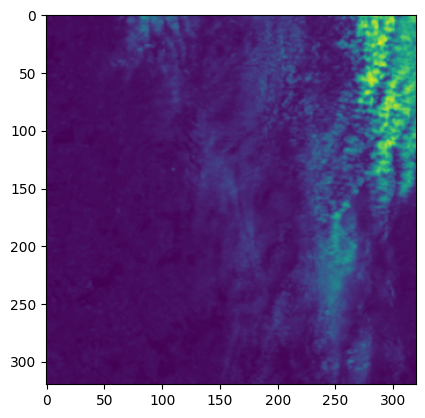

In [26]:
import matplotlib.pyplot as plt


plt.imshow(chunks_tensor[10,0,0:,:].cpu().detach().numpy())

In [27]:
chunks_grid = chunks_grid.view(B * ny * nx, C, H, W).to(device)

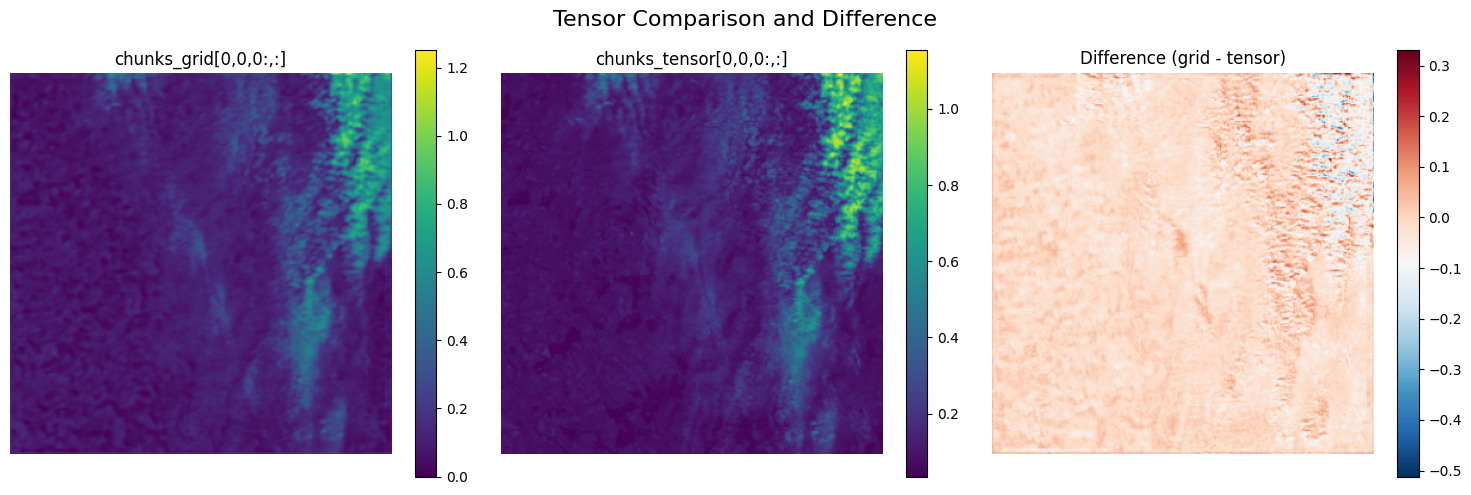

1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplot with 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Convert tensors to numpy arrays
grid_data = outputs[10,1,0:,:].cpu().detach().numpy()
tensor_data = chunks_tensor[10,1,0:,:].cpu().detach().numpy()

# Plot first tensor
im1 = axes[0].imshow(grid_data, cmap='viridis')
axes[0].set_title('chunks_grid[0,0,0:,:]')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])

# Plot second tensor
im2 = axes[1].imshow(tensor_data, cmap='viridis')
axes[1].set_title('chunks_tensor[0,0,0:,:]')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1])

# Plot difference
difference = grid_data - tensor_data
im3 = axes[2].imshow(difference, cmap='RdBu_r')  # Red-Blue colormap for difference
axes[2].set_title('Difference (grid - tensor)')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2])

# Add overall title and adjust layout
fig.suptitle('Tensor Comparison and Difference', fontsize=16)
plt.tight_layout()
plt.show()

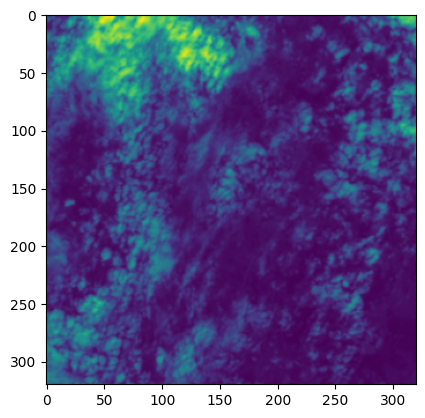

In [30]:
plt.imshow(chunks_grid[0,0,0:,:].cpu().detach().numpy())
plt.imshow(chunks_tensor[0,0,0:,:].cpu().detach().numpy())

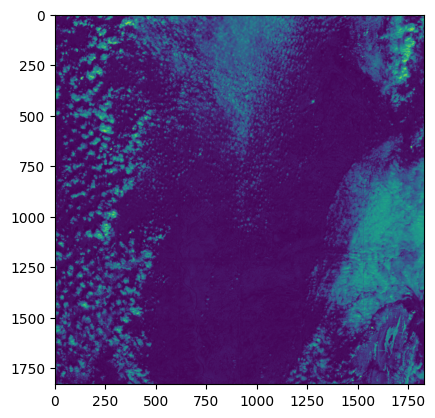

In [31]:
import matplotlib.pyplot as plt


plt.imshow(full_reconstruction[0,:,:].detach().numpy())

(-0.5, 1829.5, 1829.5, -0.5)

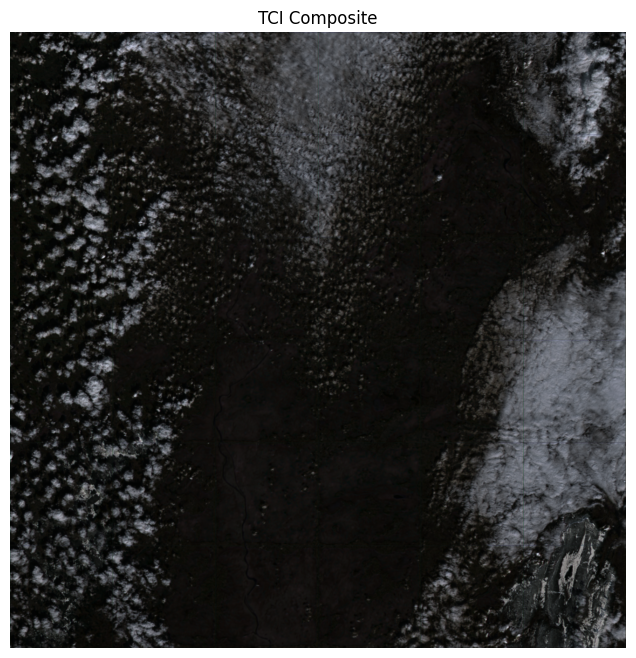

In [32]:
rgb = np.stack([
    full_reconstruction[3].detach().numpy(),  # Red (B04)
    full_reconstruction[2].detach().numpy(),  # Green (B03)
    full_reconstruction[1].detach().numpy(),  # Blue (B02)
], axis=-1)

rgb = np.clip((rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-6), 0, 1)
plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.title("TCI Composite")
plt.axis("off")

In [35]:
# Global dictionary to store activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Clear previous activations
activations.clear()

hook_handle = model[0].encoder.blocks[5].register_forward_hook(get_activation("deepest_layer"))

# Your existing forward pass
model.eval()
with torch.no_grad():
    pred_tensor = model(chunks_tensor)

# Extract the deepest layer tensor
deepest_tensor = activations["deepest_layer"]

# Clean up hook
hook_handle.remove()

print(f"Deepest layer tensor shape: {deepest_tensor.shape}")  # Should be [1, 352, H/32, W/32]

Deepest layer tensor shape: torch.Size([72, 192, 10, 10])


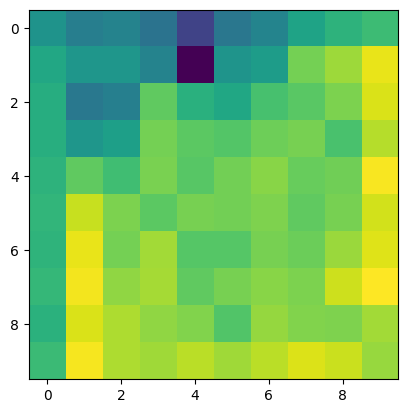

In [36]:
plt.imshow(deepest_tensor[11,100,:,:].cpu().detach().numpy())

In [37]:
# Print input tensor info
print(f"Input tensor (chunks_tensor) shape: {chunks_tensor.shape}")
print(f"Input tensor size: {chunks_tensor.numel():,} elements")

# Print bottleneck tensor info
print(f"Bottleneck tensor shape: {deepest_tensor.shape}")
print(f"Bottleneck tensor size: {deepest_tensor.numel():,} elements")

# Calculate compression ratio
compression_ratio = chunks_tensor.numel() / deepest_tensor.numel()
print(f"Compression ratio: {compression_ratio:.2f}x smaller")

# Calculate size reduction percentage
size_reduction = (1 - deepest_tensor.numel() / chunks_tensor.numel()) * 100
print(f"Size reduction: {size_reduction:.1f}%")

# Compare spatial dimensions
input_spatial = chunks_tensor.shape[2] * chunks_tensor.shape[3]
bottleneck_spatial = deepest_tensor.shape[2] * deepest_tensor.shape[3]
spatial_compression = input_spatial / bottleneck_spatial

# Compare channel dimensions
print(f"Channel expansion: {chunks_tensor.shape[1]} -> {deepest_tensor.shape[1]} channels")

Input tensor (chunks_tensor) shape: torch.Size([72, 11, 320, 320])
Input tensor size: 81,100,800 elements
Bottleneck tensor shape: torch.Size([72, 192, 10, 10])
Bottleneck tensor size: 1,382,400 elements
Compression ratio: 58.67x smaller
Size reduction: 98.3%
Channel expansion: 11 -> 192 channels
